In [59]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display

In [60]:
#Charge the data
train_data_df = pd.read_csv(r'C:\Repositorio\Titanic competition\Data\train.csv')
test_data_df = pd.read_csv(r'C:\Repositorio\Titanic competition\Data\test.csv')

In [61]:
#Feature engineering

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


In [62]:
#Prepare the data

train_data_df.drop(['Name'], axis=1, inplace=True)
test_data_df.drop(['Name'], axis=1, inplace=True)

y = train_data_df['Survived']
test_X = test_data_df
train_X, val_X, train_y, val_y = train_test_split(train_data_df, y, random_state = 0)
train_X.drop(['Survived'], axis=1, inplace=True)
val_X.drop(['Survived'], axis=1, inplace=True)


# Obtener los tipos de datos categoricos
s = (train_X.dtypes == 'object')
object_cols = list(s[s].index)





#Apply one-hot encoding to each column with categorical data and reset index
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_X[object_cols]))
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
OH_cols_test.index = test_X.index
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_X.drop(object_cols, axis=1)
num_X_valid = val_X.drop(object_cols, axis=1)
num_X_test = test_X.drop(object_cols, axis=1)
# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
#Fill the dataframes NaN
OH_X_train = OH_X_train.fillna(method='bfill', axis=0).fillna(0)
OH_X_valid = OH_X_valid.fillna(method='bfill', axis=0).fillna(0)
val_y = val_y.fillna(method='bfill', axis=0).fillna(0)
train_y = train_y.fillna(method='bfill', axis=0).fillna(0)


passenger_id_list = OH_X_test['PassengerId']


print("Categorical variables:")
print(object_cols)

C:\Python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
Categorical variables:
['Sex', 'Ticket', 'Cabin', 'Embarked']


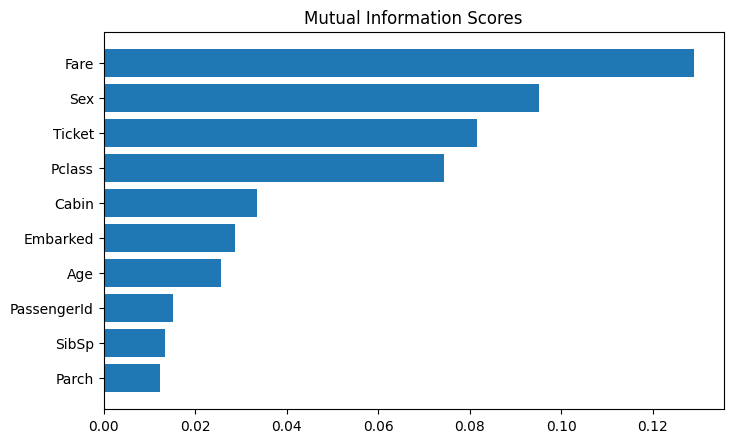

In [70]:
X = train_data_df.copy().fillna(train_data_df.mean())

y = X.pop("Survived")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)

mi_scores[:]

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [64]:
#Select & fit a model
titanic_model = XGBRegressor(n_estimators=500, learning_rate=0.05)
titanic_model.fit(OH_X_train, train_y,
                  early_stopping_rounds=1,
                  eval_set=[(OH_X_valid, val_y)])

[0]	validation_0-rmse:0.48683
[1]	validation_0-rmse:0.47434
[2]	validation_0-rmse:0.46289
[3]	validation_0-rmse:0.45223
[4]	validation_0-rmse:0.44230
[5]	validation_0-rmse:0.43268
[6]	validation_0-rmse:0.42431
[7]	validation_0-rmse:0.41663
[8]	validation_0-rmse:0.40977
[9]	validation_0-rmse:0.40326
[10]	validation_0-rmse:0.39760
[11]	validation_0-rmse:0.39182
[12]	validation_0-rmse:0.38633
[13]	validation_0-rmse:0.38152
[14]	validation_0-rmse:0.37708
[15]	validation_0-rmse:0.37310
[16]	validation_0-rmse:0.36977
[17]	validation_0-rmse:0.36673
[18]	validation_0-rmse:0.36378
[19]	validation_0-rmse:0.36084
[20]	validation_0-rmse:0.35802
[21]	validation_0-rmse:0.35586
[22]	validation_0-rmse:0.35401
[23]	validation_0-rmse:0.35248
[24]	validation_0-rmse:0.35038
[25]	validation_0-rmse:0.34965
[26]	validation_0-rmse:0.34923
[27]	validation_0-rmse:0.34828
[28]	validation_0-rmse:0.34716
[29]	validation_0-rmse:0.34630
[30]	validation_0-rmse:0.34597
[31]	validation_0-rmse:0.34537
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
#Evaluate the model(XG_Boost model)

predictions = titanic_model.predict(OH_X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(val_y,predictions)))

Mean Absolute Error: 0.24801048008315765


In [66]:
#Create submission file
final_prediction = titanic_model.predict(OH_X_test)#problema de orden??? reordenar columnas
for numer_p,passenger in enumerate(final_prediction):
    if passenger>0.8:
        final_prediction[numer_p]=int(1)
    else:
        final_prediction[numer_p]=int(0)
final_prediction = final_prediction.astype(int)
gender_submission_df = pd.DataFrame()
gender_submission_df['PassengerId'] = passenger_id_list
gender_submission_df['Survived'] = final_prediction

gender_submission_df.to_csv(r'C:\Repositorio\Titanic competition\Results\gender_submission.csv', index=False)

In [67]:
print(OH_X_train)

     PassengerId  Pclass   Age  SibSp  Parch     Fare    0    1    2    3  \
105          106       3  28.0      0      0   7.8958  0.0  1.0  0.0  0.0   
68            69       3  17.0      4      2   7.9250  1.0  0.0  0.0  0.0   
253          254       3  30.0      1      0  16.1000  0.0  1.0  0.0  0.0   
320          321       3  22.0      0      0   7.2500  0.0  1.0  0.0  0.0   
706          707       2  45.0      0      0  13.5000  1.0  0.0  0.0  0.0   
..           ...     ...   ...    ...    ...      ...  ...  ...  ...  ...   
835          836       1  39.0      1      1  83.1583  1.0  0.0  0.0  0.0   
192          193       3  19.0      1      0   7.8542  1.0  0.0  0.0  0.0   
629          630       3  36.0      0      0   7.7333  0.0  1.0  0.0  0.0   
559          560       3  36.0      1      0  17.4000  1.0  0.0  0.0  0.0   
684          685       2  60.0      1      1  39.0000  0.0  1.0  0.0  0.0   

     ...  658  659  660  661  662  663  664  665  666  667  
105  ...  0.0 

In [68]:
#Evaluate the model with Keras model

#Define the  model
model = keras.Sequential([
    layers.Dense(units=1000, activation='relu', input_shape=[11]),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(units=1000, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(units=1000, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(units=1000, activation='relu'),
    layers.Dense(1, activation='sigmoid'),

])
#Add the cross-entropy loss & accuracy metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)
#Fit the model
history = model.fit(
    OH_X_train, train_y,
    validation_data=(OH_X_valid, val_y),
    batch_size=100,
    epochs=1000,
    callbacks=[early_stopping],
   # hide the output because we have so many epochs
)


Epoch 1/1000


ValueError: in user code:

    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 11 but received input with shape (None, 674)


<AxesSubplot:>

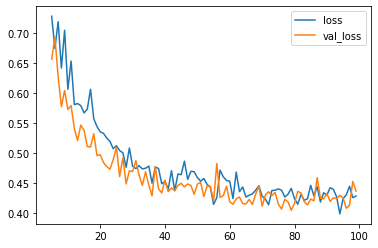

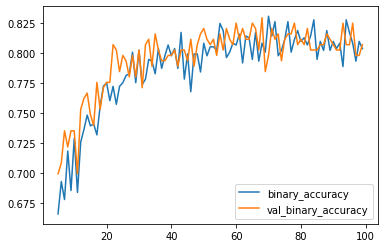

In [329]:
#history df 
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [330]:
deep_predictions = model.predict(OH_X_valid)
print(deep_predictions)

[[0.44632408]
 [0.1684914 ]
 [0.03601363]
 [0.9575824 ]
 [0.7032184 ]
 [0.46031135]
 [0.9737879 ]
 [0.9484873 ]
 [0.4297778 ]
 [0.6749378 ]
 [0.08374304]
 [0.75957453]
 [0.11620802]
 [0.9097028 ]
 [0.9859037 ]
 [0.41411152]
 [0.05657566]
 [0.22231844]
 [0.18005916]
 [0.9762732 ]
 [0.07986709]
 [0.96076775]
 [0.067496  ]
 [0.33563864]
 [0.5071659 ]
 [0.9691628 ]
 [0.18197307]
 [0.52741796]
 [0.8732557 ]
 [0.4878998 ]
 [0.22619385]
 [0.59961265]
 [0.10111472]
 [0.39133036]
 [0.13514838]
 [0.48315254]
 [0.12214375]
 [0.12089622]
 [0.0818513 ]
 [0.13577512]
 [0.24387383]
 [0.16299123]
 [0.08105212]
 [0.04210457]
 [0.9847008 ]
 [0.04913357]
 [0.04913357]
 [0.96710396]
 [0.24291351]
 [0.2896638 ]
 [0.32294804]
 [0.5498508 ]
 [0.83992434]
 [0.04981825]
 [0.41699377]
 [0.23802528]
 [0.19279623]
 [0.14489013]
 [0.08030537]
 [0.038708  ]
 [0.13256672]
 [0.60548615]
 [0.9678316 ]
 [0.52936214]
 [0.57512116]
 [0.19704792]
 [0.87717223]
 [0.2337116 ]
 [0.90046716]
 [0.97308487]
 [0.8559015 ]
 [0.35

In [331]:
#Create submission file
deep_predictions = titanic_model.predict(OH_X_test)#problema de orden??? reordenar columnas
for numer_p,passenger in enumerate(deep_predictions):
    if passenger>0.7:
        deep_predictions[numer_p]=int(1)
    else:
        deep_predictions[numer_p]=int(0)
deep_predictions = final_prediction.astype(int)
gender_submission_df = pd.DataFrame()
gender_submission_df['PassengerId'] = passenger_id_list
gender_submission_df['Survived'] = deep_predictions


gender_submission_df.to_csv(r'C:\Repositorio\Titanic competition\Results\Deep_Results\gender_submission.csv', index=False)